100%|██████████| 170498071/170498071 [00:14<00:00, 12150516.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


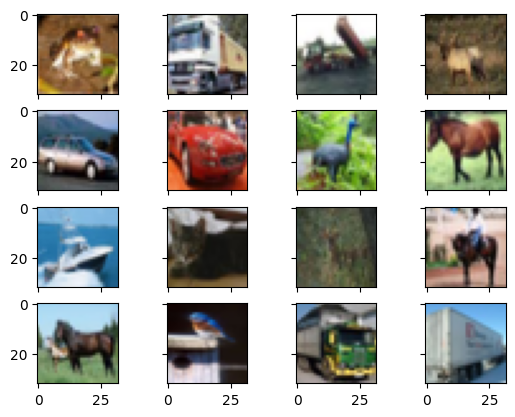

In [1]:
import matplotlib.pyplot as plt
import torchvision

train = torchvision.datasets.CIFAR10('./data', train=True, download=True)

fig, ax = plt.subplots(4, 4, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(train.data[4*i+j], cmap="gray")
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchsummary import summary

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0,), (128,)),
])
train = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=100)
testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=100)

100%|██████████| 9912422/9912422 [00:00<00:00, 287707247.71it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 118181164.71it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 107920843.23it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22571716.55it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.act3 = nn.Tanh()

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(1*1*120, 84)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # input 1x28x28, output 6x28x28
        x = self.act1(self.conv1(x))
        # input 6x28x28, output 6x14x14
        x = self.pool1(x)
        # input 6x14x14, output 16x10x10
        x = self.act2(self.conv2(x))
        # input 16x10x10, output 16x5x5
        x = self.pool2(x)
        # input 16x5x5, output 120x1x1
        x = self.act3(self.conv3(x))
        # input 120x1x1, output 84
        x = self.act4(self.fc1(self.flat(x)))
        # input 84, output 10
        x = self.fc2(x)
        return x

In [5]:
train_losses = []
test_losses = []

In [6]:
model = LeNet5()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

n_epochs = 10
for epoch in range(n_epochs):
    train_loss = 0.0
    for X_batch, y_batch in trainloader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*X_batch.size(0)
    train_loss /= len(trainloader.dataset)
    train_losses.append(train_loss)
    # Validation
    acc = 0
    count = 0
    test_loss = 0.0
    for X_batch, y_batch in testloader:
        y_pred = model(X_batch)
        acc += (torch.argmax(y_pred, 1) == y_batch).float().sum()
        count += len(y_batch)
        test_loss += loss.item()*X_batch.size(0)
    test_loss /= len(testloader.dataset)
    test_losses.append(test_loss)
    acc = acc / count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

Epoch 0: model accuracy 89.77%
Epoch 1: model accuracy 93.13%
Epoch 2: model accuracy 94.54%
Epoch 3: model accuracy 95.80%
Epoch 4: model accuracy 96.48%
Epoch 5: model accuracy 96.82%
Epoch 6: model accuracy 97.24%
Epoch 7: model accuracy 97.70%
Epoch 8: model accuracy 97.88%
Epoch 9: model accuracy 98.21%


In [8]:
# Print the summary of the model
if torch.cuda.is_available():
    model = model.cuda()
from torchsummary import summary

if torch.cuda.is_available():
    summary(model, input_size=(1, 28, 28))
else:
    summary(model.cpu(), input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
           Flatten-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             Tanh-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

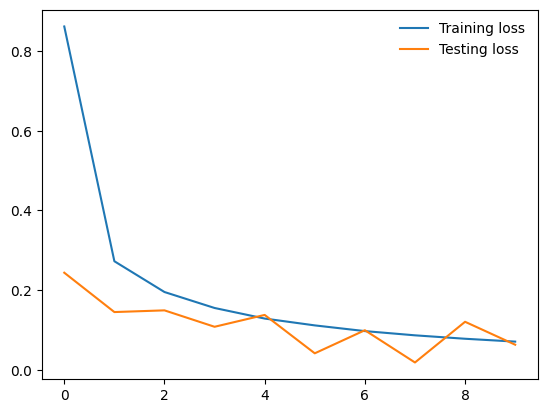

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)
plt.show()